## Data fields

Here's a brief version of what you'll find in the data description file.

* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy import stats
import xgboost as xgb
from scipy.stats import norm
#from pyglmnet import GLM # Marco: need to understand how to install this 
from sklearn.preprocessing import StandardScaler

from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')


from pandas import ExcelWriter  #Marco: this is useful to write in excel

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
#target = train.SalePrice
#train.ix[:3].columns.values

In [3]:

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [4]:
#Distribution and skewness
def distskew(dataset,feature):
    fig = plt.figure()
    sns.distplot(dataset[feature], fit=norm);
    return("Skewness = ",skew(dataset[feature].dropna()))

In [5]:
# Scatter plot
def scatplot(a,b):
    scatplotdata = pd.DataFrame({"x":a, "y":b})
    scatplotdata.plot(x = "x", y = "y", kind = "scatter")
    return()

In [6]:
#Marco: uncomment to view this plot
#scatplot(train["GrLivArea"],train["SalePrice"])
#distskew(train,"ScreenPorch")

In [7]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
print("\n train",train.shape)
print("\n test",test.shape)
print("\nall_data",all_data.shape)

#get the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#Get Categorical data in a fast way:
categorical_features = pd.DataFrame(all_data.describe(include = ['O'])).columns

prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
#prices.hist()

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])


 train (1460, 81)

 test (1459, 80)

all_data (2919, 79)


# Data Cleaning
Add here all the operation useful to remove data with comment that justify your actions (e.g. removing outliers)

In [8]:
#Remove outliers
#train.sort_values(by = 'GrLivArea', ascending = False)[:2]
#train = train.drop(train[train['Id'] == 1299].index)
#train = train.drop(train[train['Id'] == 524].index)

#train = train.drop(train[train['GrLivArea'] > 4000].index)
#train = train.drop(train[train['TotalBsmtSF'] == 0].index)

#train = train.reset_index()


#scatplot(train["GrLivArea"],train["SalePrice"])

In [9]:
#missing data
REMOVING_THRESH = 0.8

total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(10))
#MDV: remove the feature that has more than 10% of missing values
print("\n We are going to remove the below features : \n",missing_data[missing_data['Percent'] > REMOVING_THRESH])

all_data = all_data.drop((missing_data[missing_data['Percent'] > REMOVING_THRESH]).index,1)

print("\n After removed data the new dim of all_data are\n",all_data.shape)


              Total   Percent
PoolQC         2909  0.996574
MiscFeature    2814  0.964029
Alley          2721  0.932169
Fence          2348  0.804385
FireplaceQu    1420  0.486468
LotFrontage     486  0.166495
GarageCond      159  0.054471
GarageQual      159  0.054471
GarageYrBlt     159  0.054471
GarageFinish    159  0.054471

 We are going to remove the below features : 
              Total   Percent
PoolQC        2909  0.996574
MiscFeature   2814  0.964029
Alley         2721  0.932169
Fence         2348  0.804385

 After removed data the new dim of all_data are
 (2919, 75)


# Some Feature Engineering
Put here all the data manipulation 

In [10]:

all_data["TotBsmtFin"] = all_data["BsmtFinSF1"] + all_data["BsmtFinSF2"]
train["TotBsmtFin"] = train["BsmtFinSF1"] + train["BsmtFinSF2"]
                 
all_data = all_data.drop("BsmtFinSF1",1)
all_data = all_data.drop("BsmtFinSF2",1)

all_data["TotBath"] = all_data["FullBath"] + 0.5*all_data["HalfBath"] + all_data["BsmtFullBath"] + 0.5*all_data["BsmtHalfBath"]
train["TotBath"] = train["FullBath"] + 0.5*train["HalfBath"] + train["BsmtFullBath"] + 0.5*train["BsmtHalfBath"]

all_data = all_data.drop("FullBath",1)
all_data = all_data.drop("HalfBath",1)
all_data = all_data.drop("BsmtFullBath",1)
all_data = all_data.drop("BsmtHalfBath",1)

In [11]:
# Create a new feature to handle the zero values of TotalBsmtSF
#all_data["ZeroBsmt"] = 0
#all_data.loc[all_data["TotalBsmtSF"] == 0,"ZeroBsmt"] = 1

#avgTotalBsmtSF = all_data["TotalBsmtSF"].mean()
#all_data.loc[all_data["TotalBsmtSF"] == 0,"TotalBsmtSF"] = avgTotalBsmtSF

In [12]:

# Add the living areas and basement aread to create a new feature TotArea
all_data["TotArea"] = all_data["GrLivArea"] + all_data["TotalBsmtSF"]
train["TotArea"] = train["GrLivArea"] + train["TotalBsmtSF"]

# Take log of the skewed features

In [13]:
#get the index of the numerical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#for all the numeric features, calculate the skewness

#skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#Marco: here i've changed the train[numeric_feats] with all_data[numeric_feats]
#because we are working on all_data and train is just a part of it.

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness

#exctract the features with skewness higher than 75%
skewed_feats = skewed_feats[skewed_feats > 0.1]
skewed_feats = skewed_feats.index

#log transform skewed numeric features with skewness > 75%:
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

train[skewed_feats] = np.log1p(train[skewed_feats])

# Drop some features that do not help

In [14]:
all_data = all_data.drop("BsmtFinType1",1)
all_data = all_data.drop("2ndFlrSF",1)
all_data = all_data.drop("BedroomAbvGr",1)

all_data = all_data.drop("LowQualFinSF",1)
all_data = all_data.drop("3SsnPorch",1)
#all_data = all_data.drop("PoolArea",1)

#all_data = all_data.drop("GrLivArea",1)
#all_data = all_data.drop("TotalBsmtSF",1)

# Process Data

In [15]:
dummies = pd.get_dummies(all_data)
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

# Normalize the features (this does not seem to help: increases error)
#all_data = all_data.apply(lambda x: x/np.sqrt(sum(x**2)))

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [16]:
#Marco: uncomment to check this plot
#scatplot(train["GrLivArea"],train["SalePrice"])
#scatplot(train["TotalBsmtSF"],train["SalePrice"])
#scatplot(train["TotArea"],train["SalePrice"])

# Fit Model: Ridge (L2 Norm)

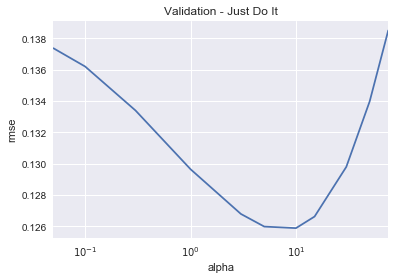

The min value of Ridge is  0.125892469649


In [17]:

#first evaluation of the regular linear regression method:
#Ridge:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
           for alpha in alphas]
    
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
#Marco: added log scale to have a better view of the minimum
plt.xscale("log")
plt.show()
print("The min value of Ridge is ",cv_ridge.min())

In [18]:
#Choose the best alpha by taking the alpha that give the lowest rmse
best_alpha = 10
# Now fit Ridge model
model_ridge = Ridge(alpha = best_alpha).fit(X_train, y)


# # Fit Model: Lasso (L1 Norm)

In [19]:
#distskew(X_train,"GrLivArea")
#distskew(X_train,"TotalBsmtSF")
#distskew(X_train,"TotArea")

The min value of Lasso is  0.121403180574
Lasso picked 102 variables and eliminated the other 160 variables


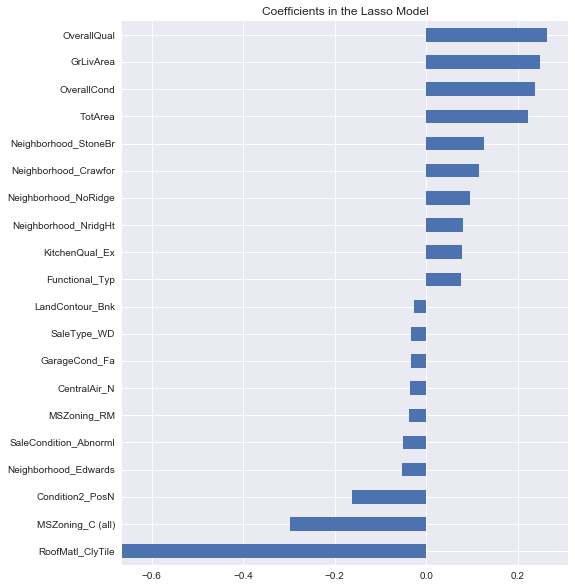

In [20]:
#Lasso:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y)
print("The min value of Lasso is ",rmse_cv(model_lasso).mean())


#Lasso choose performs also feature selection 

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#Let's look to the most important coefficients:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")  
plt.show()  

#Also note that unlike the feature importance you'd get from a random forest 
#these are actual coefficients in your model - so you can say precisely 
#why the predicted price is what it is. 
#The only issue here is that we log_transformed both the target 
#and the numeric features 
#so the actual magnitudes are a bit hard to interpret.


#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds_log = pd.DataFrame({"preds":model_lasso.predict(X_train), "true":y})
#let's return to "original" value from the log:
preds_val = np.expm1(preds_log)

#solution = pd.DataFrame({"id":test.Id, "SalePrice":preds_val})
#solution.to_csv("MDV_Lasso_v1.csv", index = False)


preds_log["residuals"] = preds_log["true"] - preds_log["preds"]



#preds_log.plot(x = "preds", y = "true",kind = "scatter")
#plt.title('Log Value ')
#plt.show()

#
#preds_val["residuals"] = preds_val["true"] - preds_val["preds"]
#preds_val.plot(x = "preds", y = "residuals",kind = "scatter")
#plt.title('Original Value in $')
#plt.show()

# Fit model: XGBoost

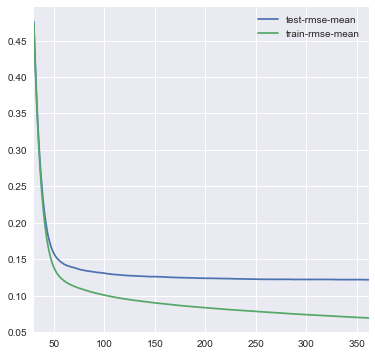

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=300, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [21]:
#Let's add an xgboost model to our linear model to see 
#if we can improve our score:

#y = preds_log["residuals"]
    
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.show()

#the params were tuned using xgb.cv
model_xgb = xgb.XGBRegressor(n_estimators=300, max_depth=2, learning_rate=0.1) 
model_xgb.fit(X_train, y)

# Now fit GLM net model

In [22]:
#model_glm = GLM(distr='gaussian')
#scaler1 = StandardScaler().fit(X_train)
#scaler2 = StandardScaler().fit(X_test)
#model_glm.fit(scaler1.transform(X_train), y)

# Now combine the models for final prediction

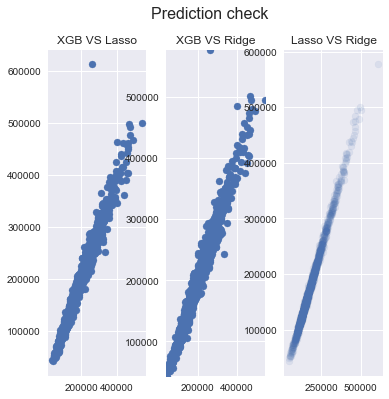

In [23]:
from matplotlib import gridspec

xgb_preds = np.expm1(model_xgb.predict(X_test))
ridge_preds = np.expm1(model_ridge.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

#Marco: I still don't have the glm available on my Jupyter env
#glm_preds = np.expm1(model_glm.predict(scaler2.transform(X_test)))
predictions_lasso = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
#predictions.plot(x = "xgb", y = "lasso", kind = "scatter")
#plt.show()

predictions_ridge = pd.DataFrame({"xgb":xgb_preds, "ridge":ridge_preds})

lasso_vs_ridge = pd.DataFrame({"lasso":lasso_preds, "ridge":ridge_preds})

fig = plt.figure()


fig.suptitle("Prediction check", fontsize=16)
ax = plt.subplot("131")
ax.set_title("XGB VS Lasso")
ax.scatter(xgb_preds,lasso_preds)

#axes = plt.gca()
#ax.set_xlim([xmin,xmax])
#axes.set_ylim([ymin,ymax])

ax = plt.subplot("132")
ax.set_title("XGB VS Ridge")
ax.scatter(xgb_preds,ridge_preds)
ax.autoscale(tight=True)

ax = plt.subplot("133")
ax.set_title("Lasso VS Ridge")
ax.scatter(lasso_preds,ridge_preds,alpha=.1)

plt.show()



#predictions_ridge = pd.DataFrame({"xgb":xgb_preds, "ridge":ridge_preds})
#predictions.plot(x = "xgb", y = "ridge", kind = "scatter")
#plt.show()



#Many times it makes sense to take a weighted average of uncorrelated results - this usually imporoves 
#the score although in this case it doesn't help that much.


In [24]:


#preds = 0.30*lasso_preds + 0.30*ridge_preds + 0.40*xgb_preds

#Marco: for now we can frozen this strategy and go ahead with feature engineering
preds = 0.60*lasso_preds + 0.40*xgb_preds

solution = pd.DataFrame({"SalePrice":preds,"id":test.Id})

#N.B. USE YOUR RELATIVE PATH HERE FOR THE CORRECT OUTPUT:
#Obaidur:
#solution.to_csv("D:/acads/ds/kaggle/house-price/my_solution_eight.csv", index = False)
#Marco
#solution.to_csv("C:\\Users\Marco Di Vivo\\Documents\\Marco\\MachineLearning\\0_Kaggle\\1_HousePrediction\\Lasso_160417.csv", index = False)


# Score Report


In [ ]:
#Marco : with the above code we get 0.11965 score on the LB   16/04/2017
